In [1]:
from math import sqrt
from sympy import Symbol
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import sympy_to_numpy_qubo

# Part 1: Setting up Subqubos

The following functions create the subqubos using the formulae in the videos as Sympy expressions. They all require the use of a var_dict variable, which will be created in the make_qubo function to relate the position of a particular variable in the Star Battle grid to its corresponding Sympy symbolic object.

In [2]:
def qubo_for_row_constraint(grid_size, var_dict, row):
    row_vars = [var_dict[(row, column)] for column in range(grid_size)]
    return (sum(row_vars) - 1)**2


def qubo_for_column_constraint(grid_size, var_dict, column):
    column_vars = [var_dict[(row, column)] for row in range(grid_size)]
    return (sum(column_vars) - 1)**2


def qubo_for_region_constraint(grid_size, var_dict, region, puzzle):
    region_indices = [i for i in range(len(puzzle)) if puzzle[i] == region]
    region_vars = [var_dict[(ind//grid_size, ind%grid_size)] for ind in region_indices]
    return (sum(region_vars) - 1)**2

# Part 2: Verifying Subqubos

Next we demonstrate some examples of the Sympy outputs for single row, column, and region restrictions for the 4x4 example puzzle below.

In [3]:
def varname(r, c):
    return 'x_' + str(r) + '_' + str(c)

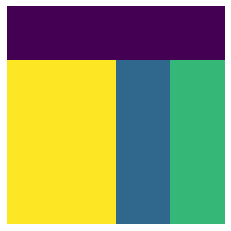

In [4]:
example_puzzle = 'AAAABBCDBBCDBBCD'
vals = {list(set(example_puzzle))[k]: k for k in range(len(set(example_puzzle)))}
plt.figure(figsize=(4,4))
plt.imshow(np.array([vals[char] for char in example_puzzle]).reshape((4,4)))
plt.axis('off')
plt.show()

In [5]:
example_var_dict = {(r,c):Symbol(varname(r,c)) for r in range(4) for c in range(4)}
row_1_constraint = qubo_for_row_constraint(4,example_var_dict, 1)
col_2_constraint = qubo_for_column_constraint(4,example_var_dict, 2)
region_B_contraint = qubo_for_region_constraint(4,example_var_dict, 'B', example_puzzle)
print(row_1_constraint,'\n')
print(col_2_constraint,'\n')
print(region_B_contraint,'\n')

(x_1_0 + x_1_1 + x_1_2 + x_1_3 - 1)**2 

(x_0_2 + x_1_2 + x_2_2 + x_3_2 - 1)**2 

(x_1_0 + x_1_1 + x_2_0 + x_2_1 + x_3_0 + x_3_1 - 1)**2 



The nice thing about representing QUBOs in Sympy is that we can expand the expression, and Sympy will keep track of all the coefficients, which will make converting to matrix form easier in the future. While the text representations of the expressions can get quite long, the QUBO logic is retained in a very convenient way.

In [6]:
print(row_1_constraint.expand(),'\n')
print(col_2_constraint.expand(),'\n')
print(region_B_contraint.expand(),'\n')

x_1_0**2 + 2*x_1_0*x_1_1 + 2*x_1_0*x_1_2 + 2*x_1_0*x_1_3 - 2*x_1_0 + x_1_1**2 + 2*x_1_1*x_1_2 + 2*x_1_1*x_1_3 - 2*x_1_1 + x_1_2**2 + 2*x_1_2*x_1_3 - 2*x_1_2 + x_1_3**2 - 2*x_1_3 + 1 

x_0_2**2 + 2*x_0_2*x_1_2 + 2*x_0_2*x_2_2 + 2*x_0_2*x_3_2 - 2*x_0_2 + x_1_2**2 + 2*x_1_2*x_2_2 + 2*x_1_2*x_3_2 - 2*x_1_2 + x_2_2**2 + 2*x_2_2*x_3_2 - 2*x_2_2 + x_3_2**2 - 2*x_3_2 + 1 

x_1_0**2 + 2*x_1_0*x_1_1 + 2*x_1_0*x_2_0 + 2*x_1_0*x_2_1 + 2*x_1_0*x_3_0 + 2*x_1_0*x_3_1 - 2*x_1_0 + x_1_1**2 + 2*x_1_1*x_2_0 + 2*x_1_1*x_2_1 + 2*x_1_1*x_3_0 + 2*x_1_1*x_3_1 - 2*x_1_1 + x_2_0**2 + 2*x_2_0*x_2_1 + 2*x_2_0*x_3_0 + 2*x_2_0*x_3_1 - 2*x_2_0 + x_2_1**2 + 2*x_2_1*x_3_0 + 2*x_2_1*x_3_1 - 2*x_2_1 + x_3_0**2 + 2*x_3_0*x_3_1 - 2*x_3_0 + x_3_1**2 - 2*x_3_1 + 1 



# Part 3: Constructing the Full QUBO

The most important function in this notebook is the make_qubo function, which combines the above subqubos with the adjacency constraint. As stated in the video, to create the full QUBO out of all the subqubos it is sufficient to add the subqubos together, which is how the function creates the Sympy expression corresponding to the full QUBO. In the final step, the Sympy symbolic expression is transformed into a Numpy array using the sympy_to_numpy_qubo function defined in sympy_to_numpy_qubo.py. The function works by using a given ordering to turn the coefficients in the symbolic expressions to entries in a Numpy matrix. The final result is the matrix representation of the QUBO and the offset that comes as a result of the constant terms. This final matrix representation is the desired form for solving our QUBO using a quantum computer.

In [7]:
def make_qubo(puzzle):

    grid_size = int(sqrt(len(puzzle)))

    var_dict = {(r, c): Symbol(varname(r, c))
                for r in range(grid_size) for c in range(grid_size)}

    qubo = 0

    for row in range(grid_size):
        qubo += qubo_for_row_constraint(grid_size, var_dict, row)

    for column in range(grid_size):
        qubo += qubo_for_column_constraint(grid_size, var_dict, column)

    for region in set(puzzle):
        qubo += qubo_for_region_constraint(grid_size, var_dict, region, puzzle)

    for row, col in var_dict.keys():
        if row != grid_size-1:
            qubo += var_dict[(row, col)] * var_dict[(row+1, col)]

        if col != grid_size-1:
            qubo += var_dict[(row, col)] * var_dict[(row, col+1)]

        if row != grid_size-1 and col != grid_size-1:
            qubo += var_dict[(row, col)] * var_dict[(row+1, col+1)]

        if row != 0 and col != grid_size-1:
            qubo += var_dict[(row, col)] * var_dict[(row-1, col+1)]

    var_order = {var:i for i, var in enumerate(var_dict.values())}

    return sympy_to_numpy_qubo.sympy_to_numpy_qubo(var_order, qubo)

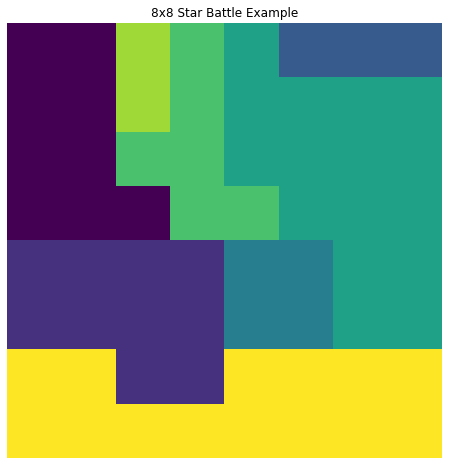

In [8]:
puzzle = "AABCDEEEAABCDDDDAACCDDDDAAACCDDDFFFFGGDDFFFFGGDDHHFFHHHHHHHHHHHH"
vals = {list(set(puzzle))[k]: k for k in range(len(set(puzzle)))}
puzzle_array = np.array([vals[char] for char in puzzle]).reshape((8,8))
plt.figure(figsize=(8,8))
plt.imshow(puzzle_array)
plt.axis('off')
plt.title('8x8 Star Battle Example')
plt.show()

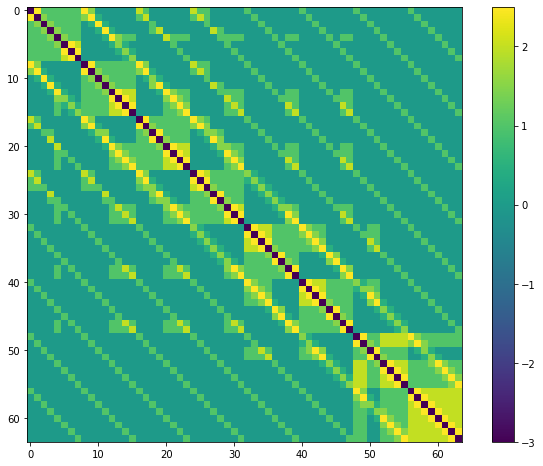

24.0


In [9]:
offset, numpy_qubo = make_qubo(puzzle)
plt.figure(figsize=(11,8))
plt.imshow(numpy_qubo)
plt.colorbar()
plt.show()
print(offset)

# Part 4: Verification on a 4x4 Example

Since the 8x8 puzzle is too computationally demanding to solve on local hardware, we can do an initial check that our QUBO works on our 4x4 example puzzle defined earlier.

In [10]:
def get_results(Q, show=False):
    # Set show=True if multiple solutions are expected
    # This parameter is good for testing that subqubos are producing satisfactory states
    mat_size = Q.shape[0]
    grid_size = int(np.sqrt(mat_size))
    states = list(product([0,1], repeat = mat_size))
    outputs = {}
    for state in states:
        x = np.array(state).reshape((mat_size,1))
        obj = x.T @ Q @ x
        outputs[state] = obj[0,0]
    minimum_value = min(outputs.values())
    solutions = [key for key in outputs if outputs[key]==minimum_value]
    if show:
        for solution in solutions:
            plt.figure(figsize=(2,2))
            plt.imshow(np.array(solution).reshape((grid_size,grid_size)))
            plt.show()
    return minimum_value, np.array(solutions[0]).reshape((grid_size,grid_size))

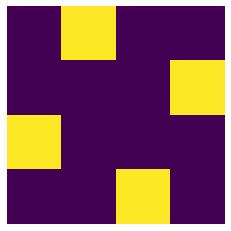

In [11]:
offset, Q = make_qubo(example_puzzle)
min_val, solution = get_results(Q)
plt.imshow(solution)
plt.axis('off')
plt.show()

The reader can check that not only is this output a valid solution to the scaled down puzzle, it is the only solution to this puzzle. Unfortunately, due to the rapid growth of the search space as the puzzle grows in size, the 8x8 case cannot be done on a local machine. For the full Star Battle puzzle, we use a powerful tool called Qatalyst.

# Part 5: Solving the Full 8x8 Puzzle

To get the final solution, we use the qcore part of a package called Qatalyst, which can solve QUBOs using quantum hardware or a powerful classical simulator depending on the function's argument. Note that this cell will not run for the standard user because it relies on having a unique token. Nevertheless, the output is the key feature in this process. For completion, we show the puzzle once again, the solution we get from Qatalyst, and an image of the official solution. One can verify that the output and official solution are the same. Moreover, the readers can check for themselves that each of the constraints are satisfied.

In [12]:
from qatalyst import qcore

url = 'https://api.qci-prod.com'
resp = qcore.sample_qubo(numpy_qubo, url=url)

Checking validity of objective function... 
Upload progress [====================] | 100.0% | Est. remaining (sec): 0.0
Job started with JobID: 60395eebcdd44cbed746af79.

Fri Feb 26 13:49:48 2021 | Problem started

Update: CSAMPLE job starting
Fri Feb 26 13:49:51 2021 | Checking again in 3 seconds...
Problem COMPLETE, returning solution.



In [13]:
import matplotlib.image as mpig
img1 = mpig.imread('puzzle_solution1.png')

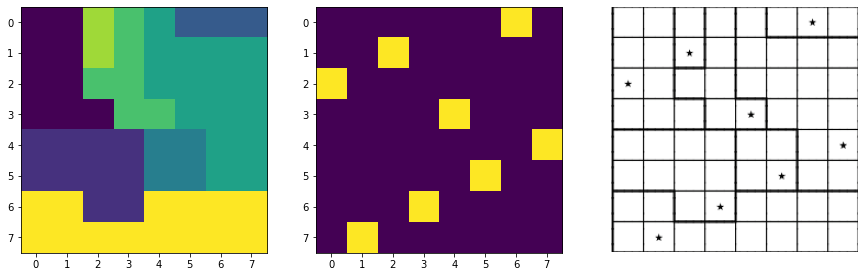

In [14]:
solution = resp.samples[0]
puzzle_solution = np.reshape(solution,(8,8))
fig, ax = plt.subplots(1,3, figsize=(15,11))
ax[0].imshow(puzzle_array)
ax[1].imshow(puzzle_solution)
ax[2].imshow(img1)
plt.axis('off')
plt.show()